<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

# Case 1: 

Using default batch size without softmax activation in output layer, without any regularization to determine the Categorical Cross-Entropy of test dataset and determine the accuracy of default model in GPU,TPU,CPU and on default mode.

## Load the libraries

In [1]:
import os
import numpy as np
import time
import tensorflow as tf
np.random.seed(6447)
tf.random.set_seed(6447)
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.datasets import fetch_openml
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [4]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
tf.config.list_physical_devices('GPU')

[]

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Define the input layer size, hidden layers size and output layer size

In [6]:
size_input = 784
size_hidden = [128,64]
size_output = 10
number_of_train_examples = 60000
number_of_test_examples = 10000

In [7]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

## Build MLP using Eager Execution

In [8]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
  def accuracy(self,  y_true, y_pred):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    acc = accuracy_score(y_true, y_pred)
    return acc

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

## Train Model

In [9]:
# Set number of epochs
NUM_EPOCHS = 10

In [10]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.41649543723739496
Number of Epoch = 1 - Accuracy:= 12.405047761292016
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.4070060727415966
Number of Epoch = 2 - Accuracy:= 12.421839096966911
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.3726960346638655
Number of Epoch = 3 - Accuracy:= 12.171425699185924
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.29517391018907563
Number of Epoch = 4 - Accuracy:= 11.815150669642858
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.295773043592437
Number of Epoch = 5 - Accuracy:= 11.337817793132878
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.3504071691176471
Number of Epoch = 6 - Accuracy:= 10.810099625787815
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.4045714285714286
Number of Epoch = 7 - Accuracy:= 10.052131204044118
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.4322915244222689
Number of Epoch = 8 - Accuracy:= 9.205090434611344
Number of Epoch = 9 - Categorica

In [11]:
# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 0.3675650932247899
Number of Epoch = 1 - Accuracy:= 6.218575100938813
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.346741662289916
Number of Epoch = 2 - Accuracy:= 6.551343388918067
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.3055718881302521
Number of Epoch = 3 - Accuracy:= 6.620254644826681
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.27229651391806725
Number of Epoch = 4 - Accuracy:= 6.265620896796219
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.270413931197479
Number of Epoch = 5 - Accuracy:= 6.529496906184348
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.2769935661764706
Number of Epoch = 6 - Accuracy:= 7.7328557887998945
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.2732294839810924
Number of Epoch = 7 - Accuracy:= 8.640414710806198
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.29185110294117644
Number of Epoch = 8 - Accuracy:= 10.163045931263131
Number of Epoch = 9 - Categorical Cros

In [12]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.22557735359768907
Number of Epoch = 1 - Accuracy:= 5.968150932247899
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.16549463300945377
Number of Epoch = 2 - Accuracy:= 4.734505789620536
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.14369055278361345
Number of Epoch = 3 - Accuracy:= 3.9210371770778623
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.12700515362394957
Number of Epoch = 4 - Accuracy:= 4.6118040966386555
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.12130336626838235
Number of Epoch = 5 - Accuracy:= 4.312644125032826
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.11806086692489495
Number of Epoch = 6 - Accuracy:= 3.699186180819984
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.11470710510766807
Number of Epoch = 7 - Accuracy:= 3.3781663910681456
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.11327781972163865
Number of Epoch = 8 - Accuracy:= 3.1395114930737917
Number of Epoch = 9 - Catego

In [13]:
#TPU mode
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='tpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc_total= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.34022311580882353
Number of Epoch = 1 - Accuracy:= 14.364687623096115
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.24267632287289917
Number of Epoch = 2 - Accuracy:= 26.53423918395483
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.20824089088760503
Number of Epoch = 3 - Accuracy:= 39.83845686712185
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.2074990644695378
Number of Epoch = 4 - Accuracy:= 54.22502379858193
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.22552781972163866
Number of Epoch = 5 - Accuracy:= 69.66366038602942
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.26027368369222686
Number of Epoch = 6 - Accuracy:= 88.86981355042018
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.38820686712184876
Number of Epoch = 7 - Accuracy:= 107.37678079044117
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.501226431197479
Number of Epoch = 8 - Accuracy:= 124.07367712710085
Number of Epoch = 9 - Categorica

## One Step Inference

In [14]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0002
Test Accuracy: 2.2667


# Case 2

Using default batch size with softmax activation in output layer, without any regularization to determine the Categorical Cross-Entropy of test dataset and determine the accuracy of default model in GPU,TPU,CPU and on default mode.

In [15]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [16]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [17]:
# Set number of epochs
NUM_EPOCHS = 10

In [18]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32) 
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 4.277167542016807
Number of Epoch = 1 - Accuracy:= 50.2974740677521
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.7885979516806723
Number of Epoch = 2 - Accuracy:= 63.77486541491597
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.2992858455882352
Number of Epoch = 3 - Accuracy:= 66.29577123818278
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.0366507352941177
Number of Epoch = 4 - Accuracy:= 67.45548434217437
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.8557383797268907
Number of Epoch = 5 - Accuracy:= 67.85714696034664
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.7166187631302521
Number of Epoch = 6 - Accuracy:= 67.9899676667542
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.6026525735294118
Number of Epoch = 7 - Accuracy:= 67.8806378019958
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.5088586528361344
Number of Epoch = 8 - Accuracy:= 67.82856814600841
Number of Epoch = 9 - Categorical Cross-Entr

In [19]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0007
Test Accuracy: 67.3524


# Case 3

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying Dropout penalty/regularization. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on default function and not mlp on other modes.

In [20]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [21]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [22]:
# Set number of epochs
NUM_EPOCHS = 10

In [23]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 4.665143382352941
Number of Epoch = 1 - Accuracy:= 50.10257599133403
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.7891188287815125
Number of Epoch = 2 - Accuracy:= 64.06885586265756
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.3091373424369748
Number of Epoch = 3 - Accuracy:= 67.86209132090336
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.054913668592437
Number of Epoch = 4 - Accuracy:= 69.90421481092437
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.8879038209033614
Number of Epoch = 5 - Accuracy:= 71.03527113970588
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.7662441570378151
Number of Epoch = 6 - Accuracy:= 71.7950121454832
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.6711848082983193
Number of Epoch = 7 - Accuracy:= 72.34461987920167
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.5949285714285715
Number of Epoch = 8 - Accuracy:= 72.69422104779412
Number of Epoch = 9 - Categorical Cross-Ent

In [24]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0010
Test Accuracy: 72.6857


# Case 4

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying l1 penalty/regularization. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on default function and not mlp on other modes.

In [25]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [26]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) # L1 = absolute sum of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.03 * L1 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [27]:
# Set number of epochs
NUM_EPOCHS = 10

In [28]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 4.035077468487395
Number of Epoch = 1 - Accuracy:= 48.757984834558826
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.552138524159664
Number of Epoch = 2 - Accuracy:= 61.884010635504204
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.0551963629201682
Number of Epoch = 3 - Accuracy:= 63.61843487394958
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.7850534401260504
Number of Epoch = 4 - Accuracy:= 63.56296776523109
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.6144686843487395
Number of Epoch = 5 - Accuracy:= 62.43858324579832
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.5011823135504202
Number of Epoch = 6 - Accuracy:= 61.13448250393908
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.42525256039915965
Number of Epoch = 7 - Accuracy:= 59.53443818933823
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.3697816767331933
Number of Epoch = 8 - Accuracy:= 57.68739741990546
Number of Epoch = 9 - Categorical Cross

In [29]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0005
Test Accuracy: 53.3810


# Case 5

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying l2 penalty/regularization. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on default function and not mlp on other modes.

In [30]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [31]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [32]:
# Set number of epochs
NUM_EPOCHS = 10

In [33]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 1.9969457720588235
Number of Epoch = 1 - Accuracy:= 3.333206817883403
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.7721226365546219
Number of Epoch = 2 - Accuracy:= 6.780364733784139
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.5773415178571428
Number of Epoch = 3 - Accuracy:= 8.01174901112789
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.4808226431197479
Number of Epoch = 4 - Accuracy:= 8.618988806460084
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.419793362657563
Number of Epoch = 5 - Accuracy:= 9.01242039784664
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.37608570772058825
Number of Epoch = 6 - Accuracy:= 9.299447708771009
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.34265867909663866
Number of Epoch = 7 - Accuracy:= 9.507119058560924
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.31567246586134456
Number of Epoch = 8 - Accuracy:= 9.668767848936449
Number of Epoch = 9 - Categorical Cross-

In [34]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0034
Test Accuracy: 63.2381


# Case 6

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying a combination of l1 and l2 penalty/regularization[Elastic Net Regularization].Dropout regularization from Keras. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on default function and not mlp on other modes.

In [35]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [36]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) # L1 = absolute sum of weights (Also known as Lasso)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.02*L1 + 0.03 * L2 # Lambda/Regularization Parameter for L1 = 0.02, Lambda/Regularization Parameter for L2 = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
  def accuracy(self,  y_true, y_pred):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = tf.math.argmax(y_true, axis=-1)
    y_pred = tf.math.argmax(y_pred, axis=-1)

    acc = accuracy_score(y_true, y_pred)
    return acc

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [37]:
# Set number of epochs
NUM_EPOCHS = 10

In [38]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc_total= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 1.7671460084033614
Number of Epoch = 1 - Accuracy:= 13.88388035878414
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.8393765099789916
Number of Epoch = 2 - Accuracy:= 20.341571198792018
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.618664325105042
Number of Epoch = 3 - Accuracy:= 27.892059069721636
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.5018616071428571
Number of Epoch = 4 - Accuracy:= 36.111578420430675
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.4271548713235294
Number of Epoch = 5 - Accuracy:= 44.75950301995798
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.3745648962710084
Number of Epoch = 6 - Accuracy:= 53.72291475183823
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.3351660976890756
Number of Epoch = 7 - Accuracy:= 62.90696395745798
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.3042320443802521
Number of Epoch = 8 - Accuracy:= 72.27388064600841
Number of Epoch = 9 - Categorical Cros

In [39]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0030
Test Accuracy: 61.2667


# Case 7

Hyper Parameter Optimization for Batch Size using Trial and Error and softmax activation on output


In [40]:
#Let Training Batch Size be 128

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [41]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [42]:
# Set number of epochs
NUM_EPOCHS = 5

In [43]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc_total= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 1.7262291228991598
Number of Epoch = 1 - Accuracy:= 96.64676339285714
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.7170543592436974
Number of Epoch = 2 - Accuracy:= 104.17673319327731
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.5700988707983193
Number of Epoch = 3 - Accuracy:= 112.49294248949579
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.4868792345063025
Number of Epoch = 4 - Accuracy:= 121.30177422531511
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.43056417410714287
Number of Epoch = 5 - Accuracy:= 130.45561974789916

Total time taken (in seconds): 65.09


In [44]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0051
Test Accuracy: 58.9714


In [45]:
#Let Training Batch Size be 15

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [46]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [47]:
# Set number of epochs
NUM_EPOCHS = 10

In [48]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(15)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 15 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 4.179804096638655
Number of Epoch = 1 - Accuracy:= 50.607901949842436
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.443171875
Number of Epoch = 2 - Accuracy:= 63.311242368040965
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.8925803571428571
Number of Epoch = 3 - Accuracy:= 65.29044938287815
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.5969323135504202
Number of Epoch = 4 - Accuracy:= 65.58296267725841
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.433682937237395
Number of Epoch = 5 - Accuracy:= 65.0743972393645
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.3494404543067227
Number of Epoch = 6 - Accuracy:= 64.46430212710084
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.29636853335084035
Number of Epoch = 7 - Accuracy:= 64.38113223805148
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.2585167574842437
Number of Epoch = 8 - Accuracy:= 64.10217182576156
Number of Epoch = 9 - Categorical Cross-Entropy

In [49]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0003
Test Accuracy: 64.7810


**From these experiments, less training batch size yields good accuracy**

# Case 8

Hyper Parameter Optimization for Learning Rate using Trial and Error

In [50]:
#Let Learning Rate be 1e-3

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [51]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [52]:
# Set number of epochs
NUM_EPOCHS = 10

In [53]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(10)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 1.1311907825630252
Number of Epoch = 1 - Accuracy:= 119.4422268907563
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.1577020417542017
Number of Epoch = 2 - Accuracy:= 118.06744025735294
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.12599798943014706
Number of Epoch = 3 - Accuracy:= 122.39025571165966
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.11327458639705883
Number of Epoch = 4 - Accuracy:= 125.81877790178571
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.10626658514968487
Number of Epoch = 5 - Accuracy:= 128.36970686712186
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.10124446888130252
Number of Epoch = 6 - Accuracy:= 131.05895483193277
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.09759325761554621
Number of Epoch = 7 - Accuracy:= 132.9885684742647
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.09430331702993698
Number of Epoch = 8 - Accuracy:= 135.1630449054622
Number of Epoch = 9 - Categor

In [54]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0001
Test Accuracy: 67.4190


In [55]:
#Let Learning Rate be 1e-5

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [56]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [57]:
# Set number of epochs
NUM_EPOCHS = 10

In [58]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(10)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 18.672939075630254
Number of Epoch = 1 - Accuracy:= 55.13989873293067
Number of Epoch = 2 - Categorical Cross-Entropy:= 8.7080131302521
Number of Epoch = 2 - Accuracy:= 93.71758469012606
Number of Epoch = 3 - Categorical Cross-Entropy:= 6.404541491596639
Number of Epoch = 3 - Accuracy:= 108.30942259716387
Number of Epoch = 4 - Categorical Cross-Entropy:= 5.239406512605042
Number of Epoch = 4 - Accuracy:= 115.72118730304621
Number of Epoch = 5 - Categorical Cross-Entropy:= 4.51012237394958
Number of Epoch = 5 - Accuracy:= 120.58829273897058
Number of Epoch = 6 - Categorical Cross-Entropy:= 3.9901670168067227
Number of Epoch = 6 - Accuracy:= 124.15173647584035
Number of Epoch = 7 - Categorical Cross-Entropy:= 3.5982914915966386
Number of Epoch = 7 - Accuracy:= 126.71284959296219
Number of Epoch = 8 - Categorical Cross-Entropy:= 3.2857865021008403
Number of Epoch = 8 - Accuracy:= 128.73983226102942
Number of Epoch = 9 - Categorical Cross-E

In [59]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0027
Test Accuracy: 65.5524


**From these experiments, higher learning rate yields good accuracy**

# Case 9

Hyper Parameter Optimisation for Activation Function using Trial and Error

In [60]:
#Let's use sigmoid

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [61]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.keras.activations.sigmoid(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.keras.activations.sigmoid(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [62]:
# Set number of epochs
NUM_EPOCHS = 10

In [63]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 0.3642765231092437
Number of Epoch = 1 - Accuracy:= 6.142939206932773
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.34774258140756303
Number of Epoch = 2 - Accuracy:= 5.905961749934349
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.33342134978991594
Number of Epoch = 3 - Accuracy:= 5.6672927471769965
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.3210939797794118
Number of Epoch = 4 - Accuracy:= 5.492502420890231
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.3104695706407563
Number of Epoch = 5 - Accuracy:= 5.460569750361082
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.30123988970588234
Number of Epoch = 6 - Accuracy:= 5.388297457654937
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.29312496717436975
Number of Epoch = 7 - Accuracy:= 5.243758001247374
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.28588881959033613
Number of Epoch = 8 - Accuracy:= 5.272328609178046
Number of Epoch = 9 - Categorical 

In [64]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0005
Test Accuracy: 5.1810


In [65]:
#Let's use tanh
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [66]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.tanh(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.tanh(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [67]:
# Set number of epochs
NUM_EPOCHS = 10

In [68]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(10)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 1.0490091911764705
Number of Epoch = 1 - Accuracy:= 25.354533219537817
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.9826112788865546
Number of Epoch = 2 - Accuracy:= 26.436868106617645
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.9291058954831932
Number of Epoch = 3 - Accuracy:= 27.68050608915441
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.8851118040966387
Number of Epoch = 4 - Accuracy:= 28.927553834033613
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.8477333902310924
Number of Epoch = 5 - Accuracy:= 30.063616071428573
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.8152284663865547
Number of Epoch = 6 - Accuracy:= 31.404762588629204
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.7864837841386555
Number of Epoch = 7 - Accuracy:= 32.665274996717436
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.7608396796218487
Number of Epoch = 8 - Accuracy:= 33.92915203190651
Number of Epoch = 9 - Categorical 

In [69]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0007
Test Accuracy: 18.1143


# Case 10

Hyper Parameter Optimisation for Optimizer using Trial and Error

In [70]:
#Let's use Adagrad
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [71]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.tanh(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.tanh(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [72]:
# Set number of epochs
NUM_EPOCHS = 10

In [73]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.52705078125
Number of Epoch = 1 - Accuracy:= 9.482398281578257
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.4901023831407563
Number of Epoch = 2 - Accuracy:= 10.077332055869222
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.4578363642331933
Number of Epoch = 3 - Accuracy:= 10.890766560530462
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.429066668855042
Number of Epoch = 4 - Accuracy:= 11.853794642857144
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.4029908088235294
Number of Epoch = 5 - Accuracy:= 12.878996520483193
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.37967233455882354
Number of Epoch = 6 - Accuracy:= 14.042015780921743
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.35908866202731093
Number of Epoch = 7 - Accuracy:= 15.443678399094013
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.34096083902310925
Number of Epoch = 8 - Accuracy:= 16.726062934939602
Number of Epoch = 9 - Categorical Cr

In [74]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0006
Test Accuracy: 19.6095


In [75]:
#Let's use Adam
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [76]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.tanh(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.tanh(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [77]:
# Set number of epochs
NUM_EPOCHS = 10

In [78]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.6735883665966387
Number of Epoch = 1 - Accuracy:= 10.509268111541491
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.4948926930147059
Number of Epoch = 2 - Accuracy:= 11.872277524290967
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.3893385963760504
Number of Epoch = 3 - Accuracy:= 16.961362181591387
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.32207221638655464
Number of Epoch = 4 - Accuracy:= 23.284062746192227
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.27694898897058823
Number of Epoch = 5 - Accuracy:= 29.00837874212185
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.2433827632615546
Number of Epoch = 6 - Accuracy:= 33.48571879923845
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.2169197413340336
Number of Epoch = 7 - Accuracy:= 37.42015165441177
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.1962352448792017
Number of Epoch = 8 - Accuracy:= 40.55129004726891
Number of Epoch = 9 - Categorical 

In [79]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0003
Test Accuracy: 46.3810


# Case 11

Calling the most optimal function 10 times and plotting the accuracy for each time: Optimal model has Dropout layer Regularization, Batch size = 20, Activation Fn = Relu, Optimizer = SGD, Learning Rate = 1e-4.

In [80]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [81]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [82]:
# Set number of epochs
NUM_EPOCHS = 4

In [83]:
#Default mode
def train():
  mlp_on_default = MLP(size_input, size_hidden, size_output)

  time_start = time.time()
  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
    acc= tf.zeros([1], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
    for inputs, outputs in train_ds:
      preds = mlp_on_default.forward(inputs) 
      outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
      preds = tf.cast(preds, dtype=tf.float32)
      accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
      acc = acc + accuracy
      loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
      lt = lt + mlp_on_default.loss(preds, outputs)
      mlp_on_default.backward(inputs, outputs)
    print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
    print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
    time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

In [86]:
accuracy_list =[]
for i in range(0,9):
  train()
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

  print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


  maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
  yTrueMax = np.array([maxposition(rec) for rec in y_test])
  yPredMax = np.array([maxposition(rec) for rec in preds])
  val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
  accuracy_list.append(val_acc)
  print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Number of Epoch = 1 - Categorical Cross-Entropy:= 4.261551995798319
Number of Epoch = 1 - Accuracy:= 53.72768267463235
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.8469971113445378
Number of Epoch = 2 - Accuracy:= 65.82179375656513
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.3773840598739495
Number of Epoch = 3 - Accuracy:= 68.53106125262605
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.1159445903361345
Number of Epoch = 4 - Accuracy:= 69.94281775210084

Total time taken (in seconds): 311.44
Test Categorical entropy loss: 0.0003
Test Accuracy: 46.3810
Number of Epoch = 1 - Categorical Cross-Entropy:= 4.074890756302521
Number of Epoch = 1 - Accuracy:= 49.96299730829832
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.6774948792016806
Number of Epoch = 2 - Accuracy:= 64.3848312762605
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.2579891018907563
Number of Epoch = 3 - Accuracy:= 67.49403394170169
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.03126457457

KeyboardInterrupt: ignored

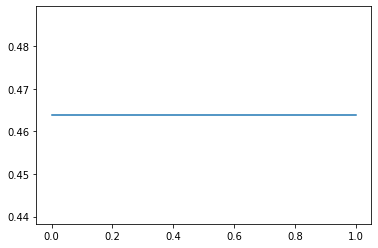

In [85]:
from matplotlib import pyplot as plt
plt.plot(accuracy_list)


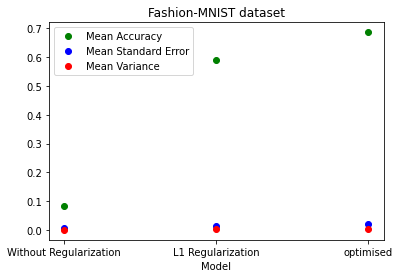

In [87]:
import numpy as np
import matplotlib.pyplot as plt

accuracy_base = np.array([6.21, 6.55, 6.62, 6.26, 6.52, 7.73, 8.64, 10.16, 11.29, 11.81])/100.0
mean_base = np.sum(accuracy_base)/accuracy_base.shape[0]
standard_dev_base = np.sqrt(np.sum((accuracy_base-mean_base)**2)/(accuracy_base.shape[0]-1.0))
standard_error_base = standard_dev_base/np.sqrt(accuracy_base.shape[0])
variance_base = standard_dev_base**2

accuracy_L1 = np.array([ 48.75, 61.88, 63.61, 63.56, 62.43, 61.13, 59.53, 57.68, 55.97, 54.48])/100.0
mean_L1 = np.sum(accuracy_L1)/accuracy_L1.shape[0]
standard_dev_L1 = np.sqrt(np.sum((accuracy_L1-mean_L1)**2)/(accuracy_L1.shape[0]-1.0))
standard_error_L1 = standard_dev_L1/np.sqrt(accuracy_L1.shape[0])
variance_L1 = standard_dev_L1**2


accuracy_optimised = np.array([50.10, 64.06, 67.86, 69.90, 71.03, 71.79, 72.34, 72.69, 72.97, 73.22])/100.0
mean_optimised = np.sum(accuracy_optimised)/accuracy_optimised.shape[0]
standard_dev_optimised = np.sqrt(np.sum((accuracy_optimised-mean_optimised)**2)/(accuracy_optimised.shape[0]-1.0))
standard_error_optimised = standard_dev_optimised/np.sqrt(accuracy_optimised.shape[0])
variance_optimised = standard_dev_optimised**2

x = np.array([0,1,2])
y_mean = np.array([mean_base, mean_L1, mean_optimised])
y_standard_error = np.array([standard_error_base, standard_error_L1, standard_error_optimised])
y_variance = np.array([variance_base, variance_L1, variance_optimised])


plt.figure(0)
my_xticks = ['Without Regularization', 'L1 Regularization', 'optimised']
plt.plot(x, y_mean, 'go', label='Mean Accuracy')
plt.plot(x, y_standard_error, 'bo', label='Mean Standard Error')
plt.plot(x, y_variance, 'ro', label='Mean Variance')
plt.xticks(x, my_xticks)
plt.xlabel('Model')
plt.title('Fashion-MNIST dataset')
plt.legend()
plt.savefig('MNIST_plots.jpg',dpi=200)

In [ ]:
from mlxtend.evaluate import bias_variance_decomp
mse, bias, var = bias_variance_decomp(mlp_on_default, x_train, y_train, x_test, y_test, loss='mse', num_rounds=200, random_seed=1)